In [10]:
# Import libraries
import torchvision
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch
import matplotlib.pyplot as plt
import time
import json
import pandas as pd

500
8
torch.Size([64, 3, 224, 224])
torch.Size([64])
tensor(0)


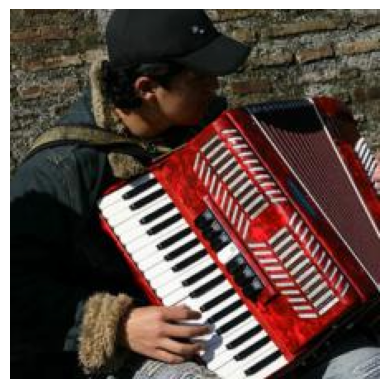

tensor(0)


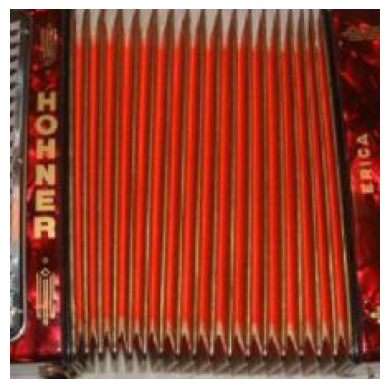

tensor(0)


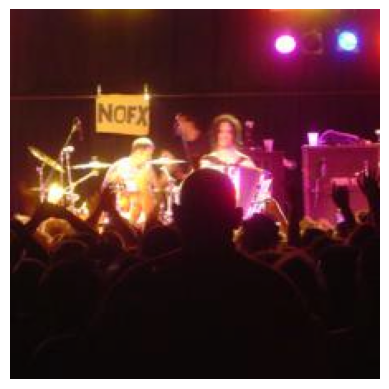

tensor(0)


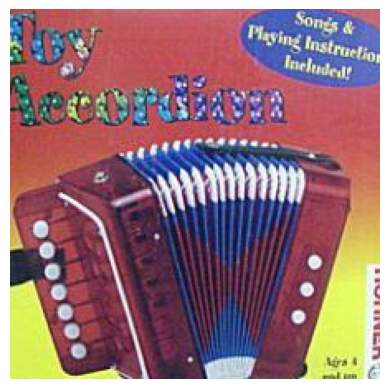

tensor(0)


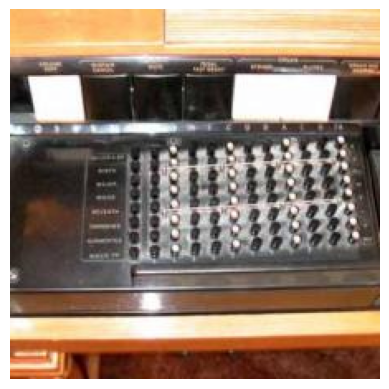

tensor(1)


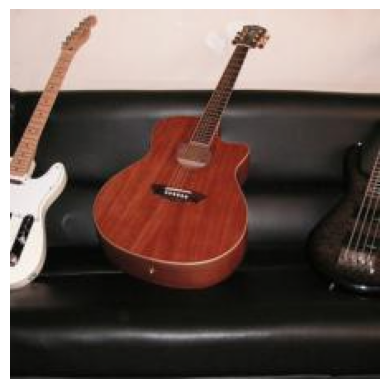

tensor(1)


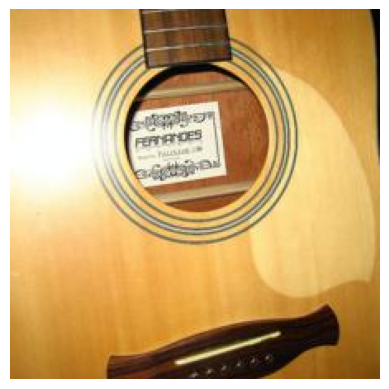

tensor(1)


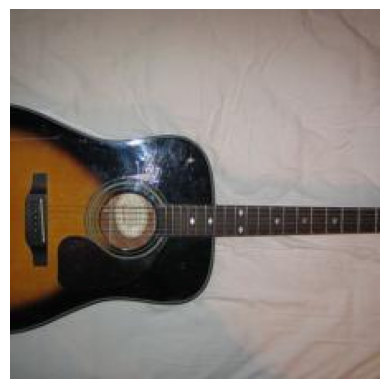

tensor(1)


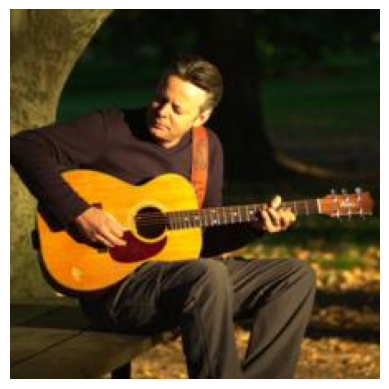

tensor(1)


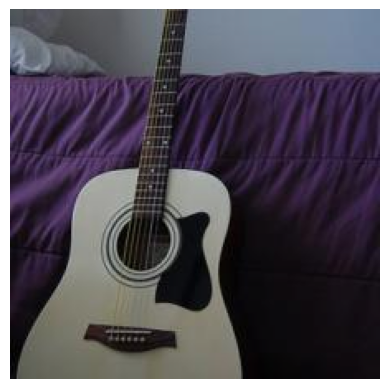

In [11]:
# Load the pre-trained ResNet-34 model with ImageNet-1K weights
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

# Define normalization parameters based on ImageNet statistics
mean_norms = np.array([0.485, 0.456, 0.406])  # Mean for each RGB channel
std_norms = np.array([0.229, 0.224, 0.225])   # Standard deviation for each RGB channel

# Compose transformations:
# - Convert images to tensors
# - Normalize using ImageNet mean and std (important for pre-trained models)
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Load the dataset from the specified path and apply the defined transformations
dataset_path = "/kaggle/input/testdataset/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# Create a DataLoader for batch processing (batch_size=64), no shuffling needed for testing
test_image_dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Print the total number of samples in the dataset
print(len(dataset))

# Print the number of batches in the DataLoader
print(len(test_image_dataloader))

# Fetch one batch of images and labels from the DataLoader
images, labels = next(iter(test_image_dataloader))

# Print the shape of the image batch (expected: [batch_size, channels, height, width])
print(images.shape)

# Print the shape of the label batch (expected: [batch_size])
print(labels.shape)

# Visualize the first 10 images from the batch along with their corresponding labels
for i in range(10):
    print(labels[i])  # Print the class label for the image

    # Convert the image tensor back to NumPy format and reverse normalization
    img_np = images[i].permute(1, 2, 0).cpu().numpy()  # Change from [C, H, W] to [H, W, C]
    img_np = img_np * std_norms + mean_norms           # Reverse normalization to original pixel values

    # Display the image
    plt.imshow(img_np)
    plt.axis('off')  # Hide axis for cleaner visualization
    plt.show()

In [12]:
# Path to the JSON file
json_path = "/kaggle/input/testdataset/TestDataSet/labels_list.json"

# Load JSON content
with open(json_path, 'r') as f:
    labels_list = json.load(f)

### Task 1

In [13]:
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

total = 0
correct = [0] * 5

with torch.no_grad():
    for images, labels in test_image_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        labels += 401

        outputs = pretrained_model(images)

        for i in range(1, 6):
            _, predicted = torch.topk(outputs.data, i, 1)
            total_correct = (predicted == labels.unsqueeze(1)).any(dim=1).sum().item()
            correct[i-1] += total_correct
        total += labels.size(0)

for i in range(5):
    print(f"Top {i+1} Accuracy: {100 * correct[i] / total:.2f}%")
    
end_time = time.time()
duration = end_time - start_time
print(f"Duration: {duration:.4f} seconds")

Top 1 Accuracy: 76.00%
Top 2 Accuracy: 86.00%
Top 3 Accuracy: 90.00%
Top 4 Accuracy: 93.20%
Top 5 Accuracy: 94.20%
Duration: 1.8788 seconds


### Task 2

In [14]:
# ── 0. Setup ─────────────────────────────────────────────────────────
label_offset = 401  # Offset to align dataset labels with ImageNet class indices (ImageNet starts from 401)
eps = 0.02          # FGSM attack budget (maximum allowed perturbation per pixel in normalized space)

# Move the pretrained model to the specified device (CPU/GPU) and set to evaluation mode
pretrained_model = pretrained_model.to(device).eval()

# Define the loss function for calculating gradients
criterion = torch.nn.CrossEntropyLoss()

start_time = time.time()  # Start timer for measuring total execution time

# ── 1. Generate adversarial examples using FGSM ──────────────────────
adv_imgs, adv_lbls = [], []  # Lists to store adversarial images and corresponding labels

for imgs, lbls in test_image_dataloader:
    imgs = imgs.to(device).clone().detach().requires_grad_(True)  # Enable gradient computation on input images
    lbls = lbls.to(device)  # Labels are kept in their raw form (0-99), without offset

    # Forward pass through the model and compute loss (apply offset only here for correct label mapping)
    outputs = pretrained_model(imgs)
    loss = criterion(outputs, lbls + label_offset)

    # Zero the gradients and backpropagate to compute gradients w.r.t. input images
    pretrained_model.zero_grad()
    loss.backward()

    # FGSM Attack: Add perturbation in the direction of the gradient sign
    perturb = eps * imgs.grad.sign()
    adv_img = imgs + perturb

    # Project adversarial images back to the ε-ball around the original image (ensures perturbation limit)
    adv_img = torch.max(torch.min(adv_img, imgs + eps), imgs - eps)

    # Store adversarial images and labels (move back to CPU and detach from computation graph)
    adv_imgs.append(adv_img.detach().cpu())
    adv_lbls.append(lbls.detach().cpu())

# Concatenate all adversarial images and labels into single tensors
adv_imgs = torch.cat(adv_imgs)
adv_lbls = torch.cat(adv_lbls)

# Save the generated adversarial dataset to a file for later evaluation
torch.save({'images': adv_imgs, 'labels': adv_lbls}, 'Adversarial Test Set 1.pt')

# ── 2. Reload & Build Dataloader ─────────────────────────────────────
saved = torch.load('Adversarial Test Set 1.pt')  # Load saved adversarial examples
adv_set = TensorDataset(saved['images'], saved['labels'])  # Create a dataset from loaded tensors
adv_loader = DataLoader(adv_set, batch_size=64, shuffle=False)  # Create a DataLoader for evaluation

# ── 3. Unified Evaluation Routine ────────────────────────────────────
def eval_top_k(loader, model, k=5, device='cpu', offset=401):
    """
    Evaluate the model's Top-k accuracy on a given dataset.

    Args:
        loader: DataLoader containing the dataset.
        model: The model to evaluate.
        k: Compute accuracy up to Top-k.
        device: CPU or GPU.
        offset: Label offset for correct mapping to ImageNet class indices.
    """
    model.eval()  # Ensure model is in evaluation mode
    correct = [0] * k  # Track correct predictions for each Top-i
    total = 0  # Total number of samples

    with torch.no_grad():  # Disable gradient computation for faster evaluation
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device) + offset  # Apply label offset here
            out = model(imgs)  # Forward pass

            for i in range(1, k + 1):
                _, pred = torch.topk(out, i, dim=1)  # Get Top-i predictions
                correct[i - 1] += (pred == lbls.unsqueeze(1)).any(dim=1).sum().item()  # Count correct predictions

            total += lbls.size(0)  # Update total number of samples

    # Print Top-1 to Top-k accuracies
    for i in range(k):
        print(f"Top-{i + 1} Accuracy: {100 * correct[i] / total:.2f}%")

# ── 4. Evaluate ──────────────────────────────────────────────────────
eval_top_k(adv_loader, pretrained_model, k=5, device=device, offset=label_offset)

# ── Execution Time Measurement ───────────────────────────────────────
end_time = time.time()
duration = end_time - start_time
print(f"Duration: {duration:.4f} seconds")  # Print total execution time

/tmp/ipykernel_31/2825236757.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved = torch.load('Adversarial Test Set 1.pt')  # Load saved adversarial examples


Top-1 Accuracy: 6.00%
Top-2 Accuracy: 19.40%
Top-3 Accuracy: 28.60%
Top-4 Accuracy: 32.40%
Top-5 Accuracy: 35.40%
Duration: 5.8577 seconds


### Task 3 - PGD attack

Duration: 58.0250 seconds


/tmp/ipykernel_31/883383539.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_pgd = torch.load('Adversarial Test Set 2.pt')


Top-1 Accuracy: 0.00%
Top-2 Accuracy: 2.80%
Top-3 Accuracy: 4.60%
Top-4 Accuracy: 7.00%
Top-5 Accuracy: 8.20%


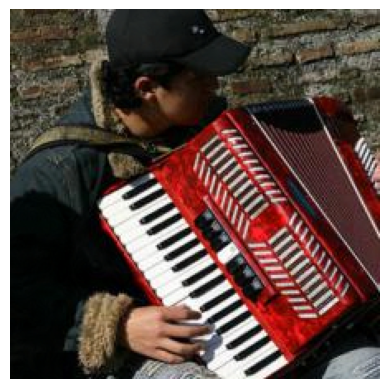

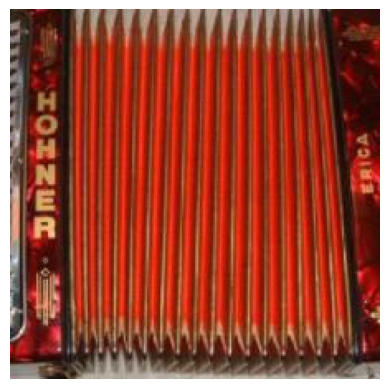

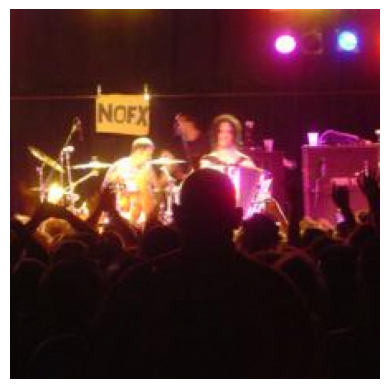

In [15]:
# ──────────────────────────────────────────────────────
# 0. Setup
# ──────────────────────────────────────────────────────
label_offset = 401             # Offset to map labels correctly to ImageNet indices
eps = 0.02                     # Attack budget (maximum perturbation allowed)
alpha = 0.005                  # Step size for each PGD iteration
n_iter = 20                    # Number of PGD iterations for a stronger attack

start_time = time.time()       # Start timing the attack process

# ──────────────────────────────────────────────────────
# 1. PGD Attack Function
# ──────────────────────────────────────────────────────
def pgd_attack(imgs, lbls, model, eps=0.02, alpha=0.005, iters=20, offset=401):
    """
    Implements Projected Gradient Descent (PGD) attack to generate adversarial examples.
    
    Args:
        imgs: Input images.
        lbls: True labels corresponding to images.
        model: Target model to attack.
        eps: Maximum perturbation allowed.
        alpha: Step size for each gradient update.
        iters: Number of attack iterations.
        offset: Label offset to match ImageNet indices.
        
    Returns:
        Adversarially perturbed images.
    """
    ori = imgs.clone().detach()  # Save original images for projection constraint
    adv = ori.clone().detach().requires_grad_(True)  # Create adversarial variable

    for _ in range(iters):
        out = model(adv)  # Forward pass on adversarial images
        loss = criterion(out, lbls + offset)  # Compute loss with offset labels
        model.zero_grad()
        loss.backward()  # Backpropagate to get gradient w.r.t. input

        # PGD update: take a small step in the direction of the gradient sign
        adv_step = adv + alpha * adv.grad.sign()

        # Project back to ensure perturbation stays within the allowed epsilon ball
        eta = torch.clamp(adv_step - ori, min=-eps, max=eps)
        adv = (ori + eta).detach().requires_grad_(True)  # Update adv and detach for next iteration

    return adv  # Return final adversarial images

# ──────────────────────────────────────────────────────
# 2. Generate Adversarial Test Set 2 using PGD
# ──────────────────────────────────────────────────────
adv_imgs_pgd, adv_lbls_pgd = [], []  # Lists to store generated adversarial examples and labels

for imgs, lbls in test_image_dataloader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    adv_imgs = pgd_attack(imgs, lbls, pretrained_model, 
                          eps=eps, alpha=alpha, iters=n_iter, 
                          offset=label_offset)
    
    adv_imgs_pgd.append(adv_imgs.detach().cpu())
    adv_lbls_pgd.append(lbls.detach().cpu())

# Concatenate all batches into tensors
adv_imgs_pgd = torch.cat(adv_imgs_pgd)
adv_lbls_pgd = torch.cat(adv_lbls_pgd)

# Measure and print total time taken
end_time = time.time()
duration = end_time - start_time
print(f"Duration: {duration:.4f} seconds")

# Save the PGD adversarial dataset to disk for later use
torch.save({'images': adv_imgs_pgd, 'labels': adv_lbls_pgd}, 'Adversarial Test Set 2.pt')

# ──────────────────────────────────────────────────────
# 3. Reload and Build Dataloader for Evaluation
# ──────────────────────────────────────────────────────
saved_pgd = torch.load('Adversarial Test Set 2.pt')
pgd_dataset = TensorDataset(saved_pgd['images'], saved_pgd['labels'])
pgd_loader = DataLoader(pgd_dataset, batch_size=64, shuffle=False)

# ──────────────────────────────────────────────────────
# 4. Evaluate Model on PGD Adversarial Set
# ──────────────────────────────────────────────────────
eval_top_k(pgd_loader, pretrained_model, k=5, device=device, offset=label_offset)

# ──────────────────────────────────────────────────────
# 5. Visualize a Few Adversarial Examples
# ──────────────────────────────────────────────────────
for i in range(3):
    np_img = saved_pgd['images'][i].permute(1, 2, 0).numpy()  # Convert from [C, H, W] to [H, W, C]
    np_img = np_img * std_norms + mean_norms  # Reverse normalization to get original pixel values
    plt.imshow(np.clip(np_img, 0, 1))  # Clip pixel values to [0, 1] for valid display
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()

### Task 4 - Patch attacks (targeted)

Duration: 164.2208 seconds


/tmp/ipykernel_31/2494329398.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_patch = torch.load('Adversarial Test Set 3.pt')


Top-1 Accuracy: 0.60%
Top-2 Accuracy: 2.40%
Top-3 Accuracy: 5.00%
Top-4 Accuracy: 7.00%
Top-5 Accuracy: 8.00%


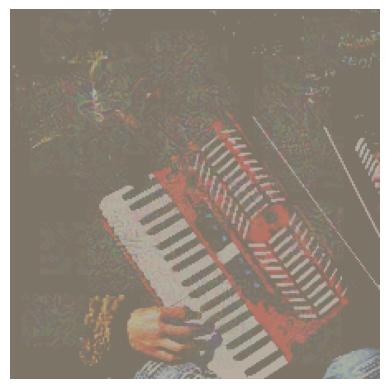

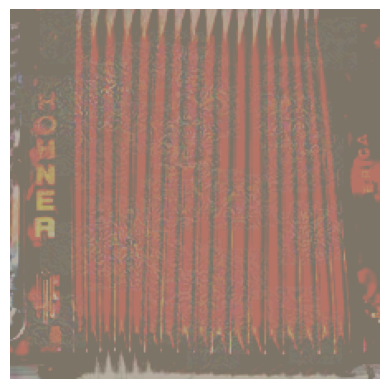

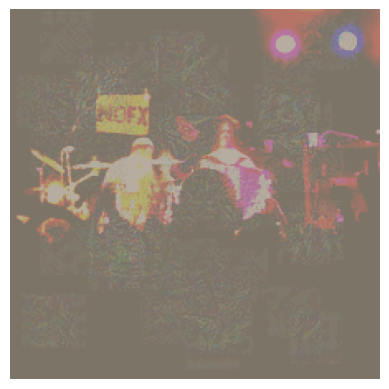

In [16]:
# ──────────────────────────────────────────────────────
# 0. Setup
# ──────────────────────────────────────────────────────
label_offset = 401
eps = 0.5             # Max allowed ε for patch attacks
alpha = 0.1            # Large step size for stronger patch update
n_iter = 20            # More iterations for stronger effect
patch_size = 32

start_time = time.time() #calculating time

# ──────────────────────────────────────────────────────
# 1. Targeted Patch PGD Attack Function
# ──────────────────────────────────────────────────────
def patch_pgd_targeted_attack(images, labels, model, patch_size=32, eps=0.5, alpha=0.1, iters=20, offset=401):
    images = images.clone().detach().to(device).requires_grad_(True)
    labels = labels.to(device)
    B, C, H, W = images.shape

    # Random target labels different from true labels
    target_labels = (labels + torch.randint(1, 100, labels.shape).to(device)) % 100

    for _ in range(iters):
        for _ in range(3):  # Apply 3 random patches per iteration
            x_start = np.random.randint(0, H - patch_size)
            y_start = np.random.randint(0, W - patch_size)
            
            mask = torch.zeros_like(images).to(device)
            mask[:, :, x_start:x_start+patch_size, y_start:y_start+patch_size] = 1.0
    
            outputs = model(images)
            loss = criterion(outputs, target_labels + offset)
            model.zero_grad()
            if images.grad is not None:
                images.grad.zero_()
            loss.backward()
    
            grad_sign = images.grad.sign() * mask
            images = images - alpha * grad_sign
            eta = torch.clamp(images - images.detach(), min=-eps, max=eps)
            images = torch.clamp(images.detach() + eta, min=0, max=1).detach().requires_grad_(True)

    return images.detach()

# ──────────────────────────────────────────────────────
# 2. Generate Adversarial Test Set 3 (Targeted Patch Attack)
# ──────────────────────────────────────────────────────
adv_images_patch, adv_labels_patch = [], []

for imgs, lbls in test_image_dataloader:
    imgs, lbls = imgs.to(device), lbls.to(device)
    adv_imgs = patch_pgd_targeted_attack(imgs, lbls, pretrained_model,
                                          patch_size=patch_size, eps=eps, alpha=alpha, iters=n_iter,
                                          offset=label_offset)

    adv_images_patch.append(adv_imgs.cpu())
    adv_labels_patch.append(lbls.cpu())

all_images_patch = torch.cat(adv_images_patch)
all_labels_patch = torch.cat(adv_labels_patch)

# ──────────────────────────────────────────────────────
end_time = time.time()
duration = end_time - start_time
print(f"Duration: {duration:.4f} seconds") # Calculating time
# ──────────────────────────────────────────────────────

torch.save({'images': all_images_patch, 'labels': all_labels_patch}, 'Adversarial Test Set 3.pt')

# ──────────────────────────────────────────────────────
# 3. Reload and Evaluate on Adversarial Test Set 3
# ──────────────────────────────────────────────────────
saved_patch = torch.load('Adversarial Test Set 3.pt')
patch_dataset = TensorDataset(saved_patch['images'], saved_patch['labels'])
patch_loader = DataLoader(patch_dataset, batch_size=64, shuffle=False)

# ──────────────────────────────────────────────────────
# 4. Evaluation
# ──────────────────────────────────────────────────────
eval_top_k(patch_loader, pretrained_model, k=5, device=device, offset=label_offset)

# ──────────────────────────────────────────────────────
# 5. Visualize Few Adversarial Patch Examples
# ──────────────────────────────────────────────────────

for i in range(3):
    np_img = saved_patch['images'][i].permute(1, 2, 0).numpy()
    np_img = np_img * std_norms + mean_norms  # De-normalize
    plt.imshow(np.clip(np_img, 0, 1))
    plt.axis('off')
    plt.show()

### Task 5 - Densenet vs Resnet

In [17]:
# Load a different pre-trained model (DenseNet-121) with ImageNet-1K weights.
# This is used to test the transferability of adversarial attacks to models other than ResNet-34.
# Move the model to the selected device (CPU or GPU) and set it to evaluation mode.
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

# Evaluate the new DenseNet-121 model on the original (clean) test dataset.
# This helps assess whether adversarial examples crafted for ResNet-34 can also degrade the performance of DenseNet-121.
eval_top_k(test_image_dataloader, new_model, k=5, device=device, offset=label_offset)

Top-1 Accuracy: 74.80%
Top-2 Accuracy: 83.80%
Top-3 Accuracy: 89.00%
Top-4 Accuracy: 90.80%
Top-5 Accuracy: 93.60%


In [18]:
# ──────────────────────────────────────────────────────
# 0. Setup
# ──────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, else CPU
label_offset = 401  # Offset to match ImageNet class indices

# ──────────────────────────────────────────────────────
# 1. Define Models for Evaluation
# ──────────────────────────────────────────────────────
models = {
    "ResNet-34": torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device).eval(),
    "DenseNet-121": torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval()
}

# ──────────────────────────────────────────────────────
# 2. Define Datasets for Evaluation
# ──────────────────────────────────────────────────────
datasets = {
    "Original (Clean)": test_image_dataloader,  # Original unperturbed test dataset

    # FGSM Adversarial Test Set 1
    "FGSM (Set 1)": DataLoader(
        TensorDataset(torch.load('Adversarial Test Set 1.pt')['images'],
                      torch.load('Adversarial Test Set 1.pt')['labels']),
        batch_size=64, shuffle=False
    ),

    # PGD Adversarial Test Set 2
    "PGD (Set 2)": DataLoader(
        TensorDataset(torch.load('Adversarial Test Set 2.pt')['images'],
                      torch.load('Adversarial Test Set 2.pt')['labels']),
        batch_size=64, shuffle=False
    ),

    # Patch Adversarial Test Set 3
    "Patch (Set 3)": DataLoader(
        TensorDataset(torch.load('Adversarial Test Set 3.pt')['images'],
                      torch.load('Adversarial Test Set 3.pt')['labels']),
        batch_size=64, shuffle=False
    )
}

# ──────────────────────────────────────────────────────
# 3. Define Evaluation Function
# ──────────────────────────────────────────────────────
def compute_accuracy(loader, model, k=5, device='cpu', offset=401):
    """
    Computes Top-1 and Top-5 accuracy for a given model and dataset.

    Args:
        loader: DataLoader for the dataset.
        model: Model to evaluate.
        k: Compute up to Top-k accuracy.
        device: 'cpu' or 'cuda'.
        offset: Label offset for correct class indices.

    Returns:
        Tuple of (Top-1 Accuracy, Top-5 Accuracy) rounded to two decimal places.
    """
    model.eval()
    corr = [0] * k  # Correct predictions for each Top-i
    tot = 0         # Total number of samples

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device) + offset
            out = model(imgs)

            # Compute correct predictions for Top-1 to Top-k
            for i in range(1, k+1):
                _, pred = torch.topk(out, i, dim=1)
                corr[i-1] += (pred == lbls.unsqueeze(1)).any(dim=1).sum().item()

            tot += lbls.size(0)

    top1_acc = 100 * corr[0] / tot
    top5_acc = 100 * corr[4] / tot
    return round(top1_acc, 2), round(top5_acc, 2)

# ──────────────────────────────────────────────────────
# 4. Evaluate All Models on All Datasets and Collect Results
# ──────────────────────────────────────────────────────
results = []

for model_name, model in models.items():
    for dataset_name, loader in datasets.items():
        top1, top5 = compute_accuracy(loader, model, k=5, device=device, offset=label_offset)
        results.append({
            "Model": model_name,
            "Dataset": dataset_name,
            "Top-1 Accuracy (%)": top1,
            "Top-5 Accuracy (%)": top5
        })

# ──────────────────────────────────────────────────────
# 5. Display Results in Tabular Format
# ──────────────────────────────────────────────────────
df = pd.DataFrame(results)
df        

/tmp/ipykernel_31/960393785.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TensorDataset(torch.load('Adversarial Test Set 1.pt')['images'],
/tmp/ipykernel_31/960393785

,Model,Dataset,Top-1 Accuracy (%),Top-5 Accuracy (%)
0,ResNet-34,Original (Clean),76.0,94.2
1,ResNet-34,FGSM (Set 1),6.0,35.4
2,ResNet-34,PGD (Set 2),0.0,8.2
3,ResNet-34,Patch (Set 3),0.6,8.0
4,DenseNet-121,Original (Clean),74.8,93.6
5,DenseNet-121,FGSM (Set 1),63.4,89.2
6,DenseNet-121,PGD (Set 2),64.0,90.4
7,DenseNet-121,Patch (Set 3),29.8,49.2
